# Restrict region by convex hull

Procedure:
* Makes convex hull based on particle positions
* Expands the hull (optional)
* Intersects region with the hull (optional)

Other info
* All operations are performed in 3D

## Initialization

In [1]:
import sys
import os
import pathlib

import numpy as np
import scipy as sp
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pyto
from pyto.spatial.multi_particle_sets import MultiParticleSets
from pyto.geometry.convex_hull_util import ConvexHullUtil

from common import show_2d_slices 

# convenience
%autosave 0
sys.version

Autosave disabled


'3.13.3 | packaged by conda-forge | (main, Apr 14 2025, 20:44:03) [GCC 13.3.0]'

In [2]:
# Settings

# force showing all rows in a table (default 60 rows)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# set hostname
hostname = os.uname()[1]
print(f"Host: {hostname}")

Host: rauna


## Convex hull

### Make region image

In [3]:
# Make region image

# Alternatively, an existing region image 

# path to region image
region_path = 'hull/region.mrc'

x_max = 40
y_max = 20
region = np.zeros((x_max, y_max, 20), dtype=int)
region[5:25, 5:10, 2:8] = 1
region[20:35, 10:15, 3:7] = 1

# save as mrc
region_image = pyto.segmentation.Labels(data=region)
region_image.write(file=region_path, dataType='int16')
print(f"Wrote image {region_path}")

Wrote image hull/region.mrc


### Read region image

In [4]:
# Read a region image
#
# Can be used to read the image generated above, of any other
# label (integer) mrc image (tomo) that contains a region

# path to region image
region_path = 'hull/region.mrc'

# region id
segment_id = 1

region_image = pyto.segmentation.Labels.read(file=region_path)
print(f"Read image {region_path}")

Read image hull/region.mrc


### Read particle data

Only one of the two cells in this section should be executed

In [5]:
# Alternative 1: Read pickled particle data object
#
# To be used when particle data are already provided as a
# pyto.spatial.MultiParticleSets object

# path to the MultiParticleSets object
mps_path = "mps_hull.pkl"

mps = MultiParticleSets.read(path=mps_path)

Read  MPS object mps_hull.pkl


In [6]:
# Alternative 2: Read from star file and generate particles object 
#
# To be used when particle data is available in a star file

# star path
star_path = 'particles_hull.star'

# star file table name
table_name = 'data_particles'

# initialize particle object and set star file related attributes
mps = MultiParticleSets()
mps.micrograph_label = 'rlnTomoName'
mps.tablename = table_name
mps.image_label = 'rlnTomoParticleId'

# import star file data
mps.particles = mps.read_star(
    path=star_path, mode='particle', tomo_id_mode=None, 
    tablename=table_name, pixel_size_nm=1, find_region_shape=False)
print(f"Read image {star_path}")
mps.tomos = pd.DataFrame({
    mps.tomo_id_col: mps.particles[mps.tomo_id_col].unique(),
    mps.region_col: region_path})

Read image particles_hull.star


### Show data

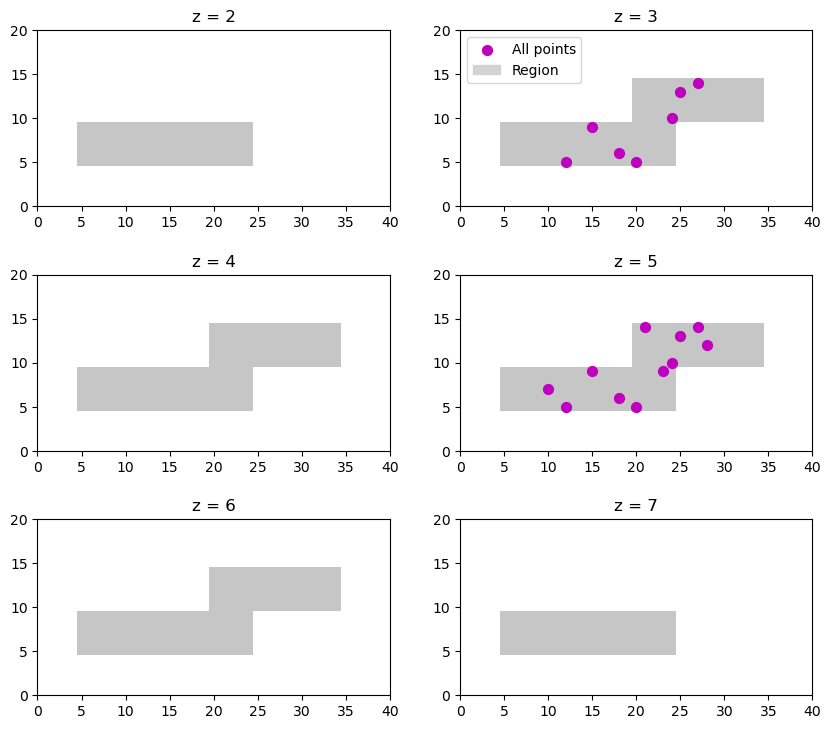

In [7]:
# Show regions and points

# marker size
markersize = 50

# Show results
z_slices = range(2, 8)
fig, axes = show_2d_slices(
    image=region[:, :, z_slices], vmin=0, vmax=3, figheight=9, figwidth=10, 
    n_cols=2)
for ax, z_coord in zip(axes.flat, z_slices):
    coords = mps.particles.query(
        "z_orig == @z_coord")[['x_orig', 'y_orig']].values
    if len(coords) > 0:
        ax.scatter(
            coords[:, 0], coords[:, 1], color='m', s=markersize, 
            label='All points')
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"z = {z_coord}")

# add labels
handles, labels = axes[0, 1].get_legend_handles_labels()
patch = mpatches.Patch(color='lightgrey', label='Region')
handles.append(patch) 
axes[0, 1].legend(handles=handles);

## Generate convex hull 

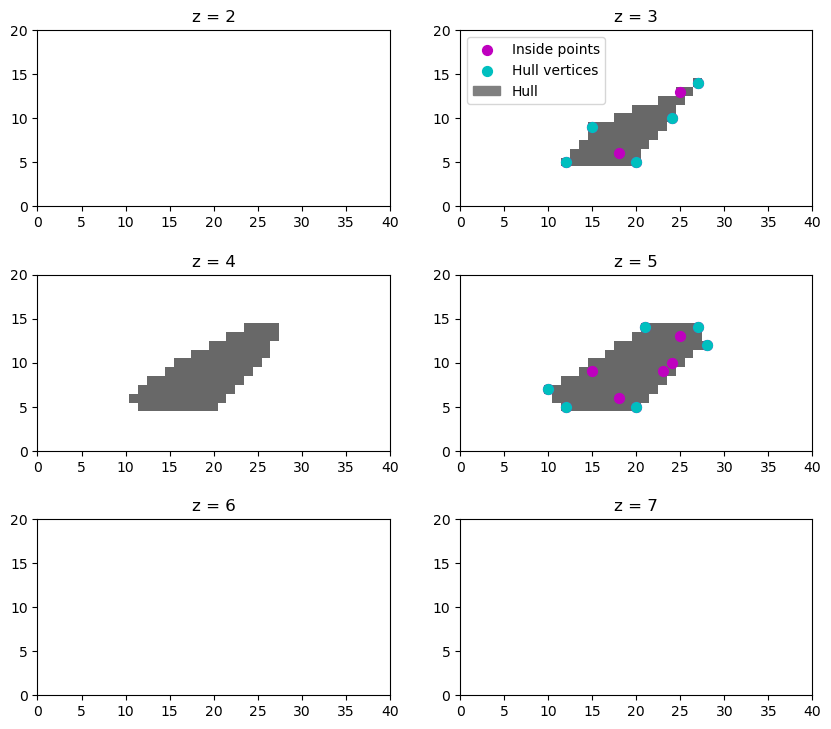

In [8]:
# Generate convex hull without expansion and intersection with region

# marker size
markersize = 50

# make hull
full = np.ones_like(region_image.data, dtype=int)
points = mps.particles[mps.orig_coord_cols].values
restricted_image, hull = ConvexHullUtil.intersect_segment(
    hull_points=points, segment=full, segment_id=1)

# Show results
z_slices = range(2, 8)
image = 2*np.array(restricted_image.data)

fig, axes = show_2d_slices(
    image=image[:, :, z_slices], vmin=0, vmax=3, figheight=9, figwidth=10, 
    n_cols=2)
for ax, z_coord in zip(axes.flat, z_slices):

    coords = mps.particles.query(
        "z_orig == @z_coord")[['x_orig', 'y_orig']].values
    vertices = np.array([
        points[ver] for ver in hull.vertices if points[ver, 2] == z_coord])
    if len(coords) > 0:
        ax.scatter(
            coords[:, 0], coords[:, 1], color='m', s=markersize, 
            label='Inside points')
    if len(vertices) > 0:
        ax.scatter(
            vertices[:, 0], vertices[:, 1], color='c', s=markersize, 
            label='Hull vertices')

    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"z = {z_coord}")

# add labels
handles, labels = axes[0, 1].get_legend_handles_labels()
patch = mpatches.Patch(color='grey', label='Hull')
handles.append(patch) 
axes[0, 1].legend(handles=handles);

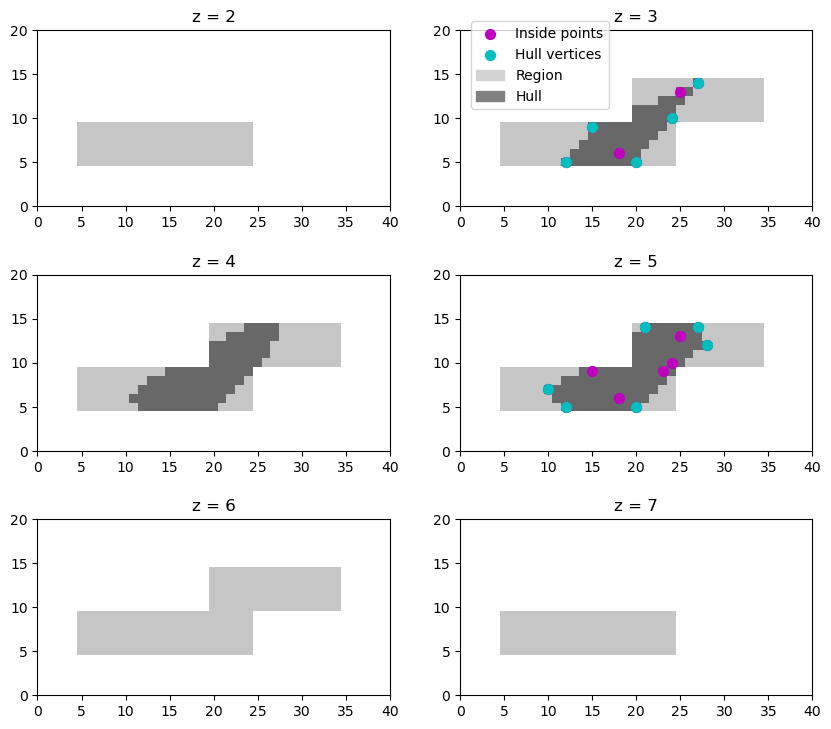

In [9]:
# Generate convex hull without expansion and intersect with region

# marker size
markersize = 50

# make hull
points = mps.particles[mps.orig_coord_cols].values
restricted_image, hull = ConvexHullUtil.intersect_segment(
    hull_points=points, segment=region_image, segment_id=1,
    expand=0)

# Show results
z_slices = range(2, 8)
image = region + restricted_image.data

fig, axes = show_2d_slices(
    image=image[:, :, z_slices], vmin=0, vmax=3, figheight=9, figwidth=10, 
    n_cols=2)
for ax, z_coord in zip(axes.flat, z_slices):

    coords = mps.particles.query(
        "z_orig == @z_coord")[['x_orig', 'y_orig']].values
    vertices = np.array([
        points[ver] for ver in hull.vertices if points[ver, 2] == z_coord])
    if len(coords) > 0:
        ax.scatter(
            coords[:, 0], coords[:, 1], color='m', s=markersize, 
            label='Inside points')
    if len(vertices) > 0:
        ax.scatter(
            vertices[:, 0], vertices[:, 1], color='c', s=markersize, 
            label='Hull vertices')

    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"z = {z_coord}")

# add labels
handles, labels = axes[0, 1].get_legend_handles_labels()
patch = mpatches.Patch(color='lightgrey', label='Region')
handles.append(patch) 
patch = mpatches.Patch(color='grey', label='Hull')
handles.append(patch) 
axes[0, 1].legend(handles=handles, loc=(0.03, 0.55));

Wrote image hull/restricted.mrc


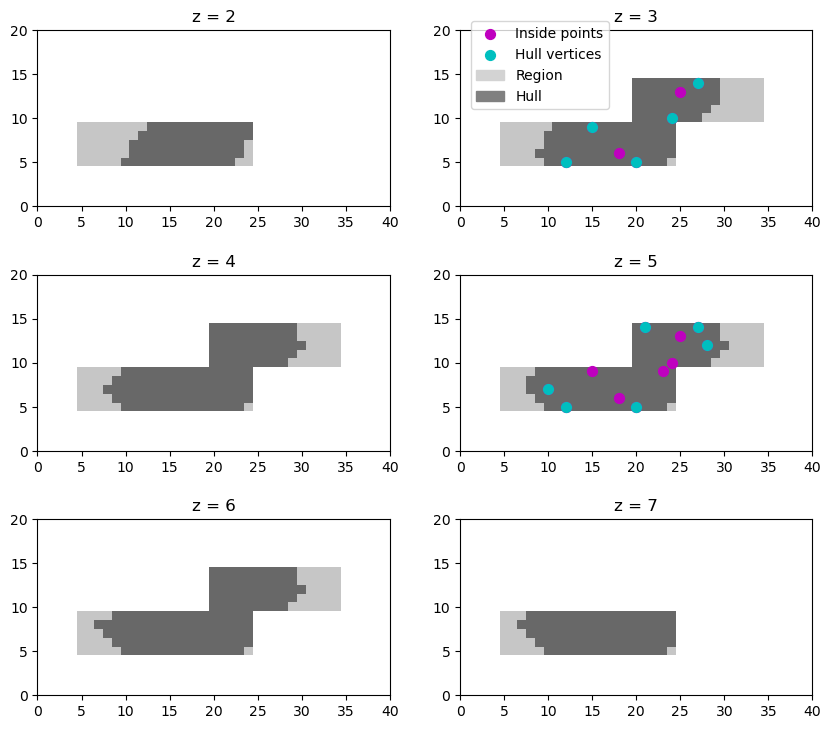

In [10]:
# Generate convex hull with expansion and intersect with region

# hull expansion [pixels]
expand = 2

# restricted region path
restricted_path = 'hull/restricted.mrc'

# marker size
markersize = 50

# make hull
points = mps.particles[mps.orig_coord_cols].values
restricted_image, hull = ConvexHullUtil.intersect_segment(
    hull_points=points, segment=region_image, segment_id=1,
    expand=expand)

# save restricted region
restricted_image.write(file=restricted_path, dataType='int16')
print(f"Wrote image {restricted_path}")

# Show results
z_slices = range(2, 8)
image = region + restricted_image.data

fig, axes = show_2d_slices(
    image=image[:, :, z_slices], vmin=0, vmax=3, figheight=9, figwidth=10, 
    n_cols=2)
for ax, z_coord in zip(axes.flat, z_slices):

    coords = mps.particles.query(
        "z_orig == @z_coord")[['x_orig', 'y_orig']].values
    vertices = np.array([
        points[ver] for ver in hull.vertices if points[ver, 2] == z_coord])
    if len(coords) > 0:
        ax.scatter(
            coords[:, 0], coords[:, 1], color='m', s=markersize, 
            label='Inside points')
    if len(vertices) > 0:
        ax.scatter(
            vertices[:, 0], vertices[:, 1], color='c', s=markersize, 
            label='Hull vertices')

    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"z = {z_coord}")

# add labels
handles, labels = axes[0, 1].get_legend_handles_labels()
patch = mpatches.Patch(color='lightgrey', label='Region')
handles.append(patch) 
patch = mpatches.Patch(color='grey', label='Hull')
handles.append(patch) 
axes[0, 1].legend(handles=handles, loc=(0.03, 0.55));